# Hurricane Research: EDA
This notebook will perform some intital EDA on the hurricane assignment from stats

Data is from http://weather.unisys.com/hurricane/atlantic/index.php, and is the year 2010 best of.

In [24]:
import numpy
import pandas
import seaborn
import auto_arima
from multiprocessing import Pool
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import poisson
%matplotlib inline

Data is imported as a no-header csv, and the column names are added

In [2]:
hurricane_raw = pandas.read_csv("hurricane.csv", header=None)
hurricane_raw.columns = [
                        'year', 'month', 'day', 
                        'hour', 'storm_year_id',
                        'name', 'latitude', 'longitude',
                        'wind_speed', 'pressure'
                        ]

In [6]:
hurricane_raw.head()

,year,month,day,hour,storm_year_id,name,latitude,longitude,wind_speed,pressure
0,2000,6,7,18,1,NOT_NAMED,21.0,-93.0,25,0
1,2000,6,8,0,1,NOT_NAMED,20.9,-92.8,25,0
2,2000,6,8,6,1,NOT_NAMED,20.7,-93.1,25,0
3,2000,6,8,12,1,NOT_NAMED,20.8,-93.5,25,0
4,2000,6,23,0,2,NOT_NAMED,9.5,-19.8,25,0


We wish to look at only named storms, so we'll filter on that

In [4]:
has_name = hurricane_raw.name != "NOT_NAMED"
named = hurricane_raw[has_name]

In [5]:
storm_matrix = named.get_values()
storm_dict = {}
for row in storm_matrix:
    key = row[5] + str(row[0]) 
    if key not in storm_dict:
        storm_dict[key] = []
    date = row[:4]
    data = row[6:]

    storm_dict[key].append(numpy.append(date, data))

`storm_dict` is now a dictonary, where each entry is an individual storm

In [9]:
def poly_want_a_storm(storm, degree=2, idx=0):
    """
    Fit a polynomial of regression to a single storm

    Arguments
    ---------
    storm -- a single storm from the storm dict. An array of small arrays
    degree -- polynomial degree; default of 2
    idx -- index of the miniarrays that is being fit
    """
    y = []
    x = []
    for i, time in enumerate(storm):
        y.append(i)
        x.append(time[idx])
    
    coeff = numpy.polyfit(y,x,degree)

    return coeff

Now we'll check to see if the function works.

In [10]:
poly_want_a_storm(storm_dict["ALBERTO2000"], idx=2)

array([  5.30022881e-06,   2.49744661e-01,   3.37427354e+00])

It appears to produce the correct results. Now we can apply it to the entire data set and collect the coefficients.

In [11]:
coeffs = []
for k, v in storm_dict.items():
    c = poly_want_a_storm(v, degree=2, idx=2)
    coeffs.append(c)

coeffs = numpy.array(coeffs)

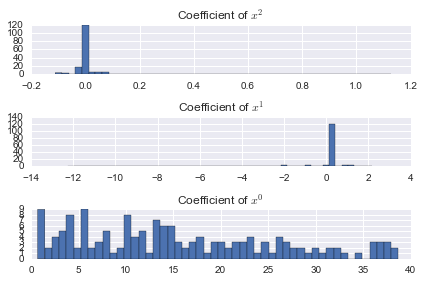

In [12]:
%matplotlib inline
deg = 2
nbin = 50

fig, axes = pyplot.subplots(3)
i = 0
for ax in axes:
        ax.hist(coeffs[:,i], nbin)
        ax.set_title("Coefficient of $x^{}$".format(deg - i))
        i += 1
fig.tight_layout()

In [13]:
coeffs = []
for k, v in storm_dict.items():
    c = poly_want_a_storm(v, degree=3, idx=2)
    coeffs.append(c)

coeffs = numpy.array(coeffs)

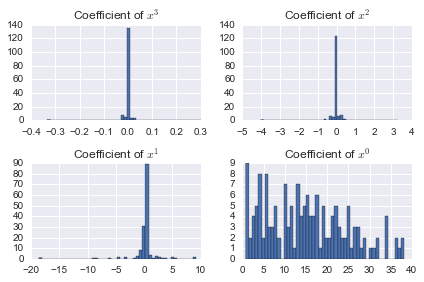

In [14]:
rows = 2
cols = 2
deg = 3
nbin = 50

fig, axes = pyplot.subplots(rows,cols)
i = 0
for row in axes:
    for ax in row:
        ax.hist(coeffs[:,i], nbin)
        ax.set_title("Coefficient of $x^{}$".format(deg - i))
        i += 1
fig.tight_layout()

# Time Series and ARIMA Model

In [6]:
def date_convert(array):
    return datetime(*array)


def generate_ts(storm, data_idx=6):
    """
    Arguments
    ---------
    storm -- single storm from storm_dict
    """
    dates = [date_convert(x[:4]) for x in storm]
    data = [ float(x[data_idx]) for x in storm]

    return pandas.Series(data, dates).interpolate(method='time')


# def get_aic(ts, pdq, *args):
#     """
#     Fits and returns ARIMA model aic for a give time series

#     Arguments
#     --------
#     ts -- time series; pandas.Series
#     pdq -- ARIMA order

#     """
#     model = ARIMA(ts, pdq, *args).fit()
#     return model.aic


# def auto_arima(ts, order):
#     """
#     Auto_arima function like R's

#     Arguments
#     ---------
#     ts -- time series being fit
#     order -- max pdq for ARIMA model

#     Returns
#     -------
#     order_min -- order of minimim aic
#     aic_min -- minimum aic
#     """
#     p = list(range(order[0] + 1))
#     d = list(range(order[1] + 1))
#     q = list(range(order[2] + 1))

#     combinations = []
#     for i in p:
#         for j in d:
#             for k in q:
#                 combinations.append((i,j,k))

#     aic_min = None
#     order_min = None
#     aic = None
#     for c in combinations:
#         try:
#             aic = get_aic(ts, c)
#             if aic_min == None or aic_min > aic:
#                 aic_min = aic
#                 order_min = c
#         except:
#             pass
    
#     return order_min, aic

In [7]:
test_storm = storm_dict["ALBERTO2000"]
ts = generate_ts(test_storm)

In [8]:
arima = ARIMA(ts, (1,2,2)).fit()
arima.aic

483.4414090914579

In [9]:
auto_arima.auto_arima(ts, (2,2,2))

((1, 2, 2), 486.80765766740456)

In [13]:
pool = Pool(4)

pdqs = []
max_idx = len(storm_dict)
winds = []
for key, values in storm_dict.items():
    ts = generate_ts(values)
    winds.append(ts)
#     pdq, order = auto_arima(ts, (2,2,2))
#     pdqs.append(pdq)

result = pool.map(auto_arima.map_arima, winds)
pool.close()
pool.join()

In [14]:
result

[((2, 1, 2), 486.73030113858437),
 ((1, 2, 0), 106.81636625133692),
 ((0, 2, 2), 219.04686374917435),
 ((0, 2, 0), 91.52429269041342),
 ((2, 2, 1), 426.82688996221964),
 ((0, 2, 1), 312.34301640011756),
 ((2, 1, 1), 327.53038466375745),
 ((3, 2, 1), 124.61586086640287),
 ((1, 2, 1), 132.0535379450029),
 ((0, 2, 3), 115.24377698837108),
 ((0, 2, 2), 366.79730876405074),
 ((0, 2, 1), 236.74021624932982),
 ((0, 2, 0), 51.472854429392086),
 ((1, 2, 0), 96.17380382485172),
 ((0, 2, 1), 141.43970894159384),
 ((0, 2, 2), 40.08229034648218),
 ((0, 2, 3), 104.29277230786674),
 ((0, 2, 1), 260.1109546783616),
 ((0, 2, 1), 244.2083894867141),
 ((1, 2, 1), 257.3007305019969),
 ((0, 2, 1), 95.57217868435964),
 ((0, 1, 0), 68.4397503901782),
 ((1, 2, 1), 290.40321033782976),
 ((0, 2, 2), 376.8559828059016),
 ((0, 2, 1), 70.43123210690459),
 ((0, 2, 2), 181.0346553095074),
 ((0, 2, 0), 98.99917191380433),
 ((2, 2, 1), 302.5142879279035),
 ((2, 1, 2), 205.67237722561882),
 ((1, 2, 0), 257.634501065183

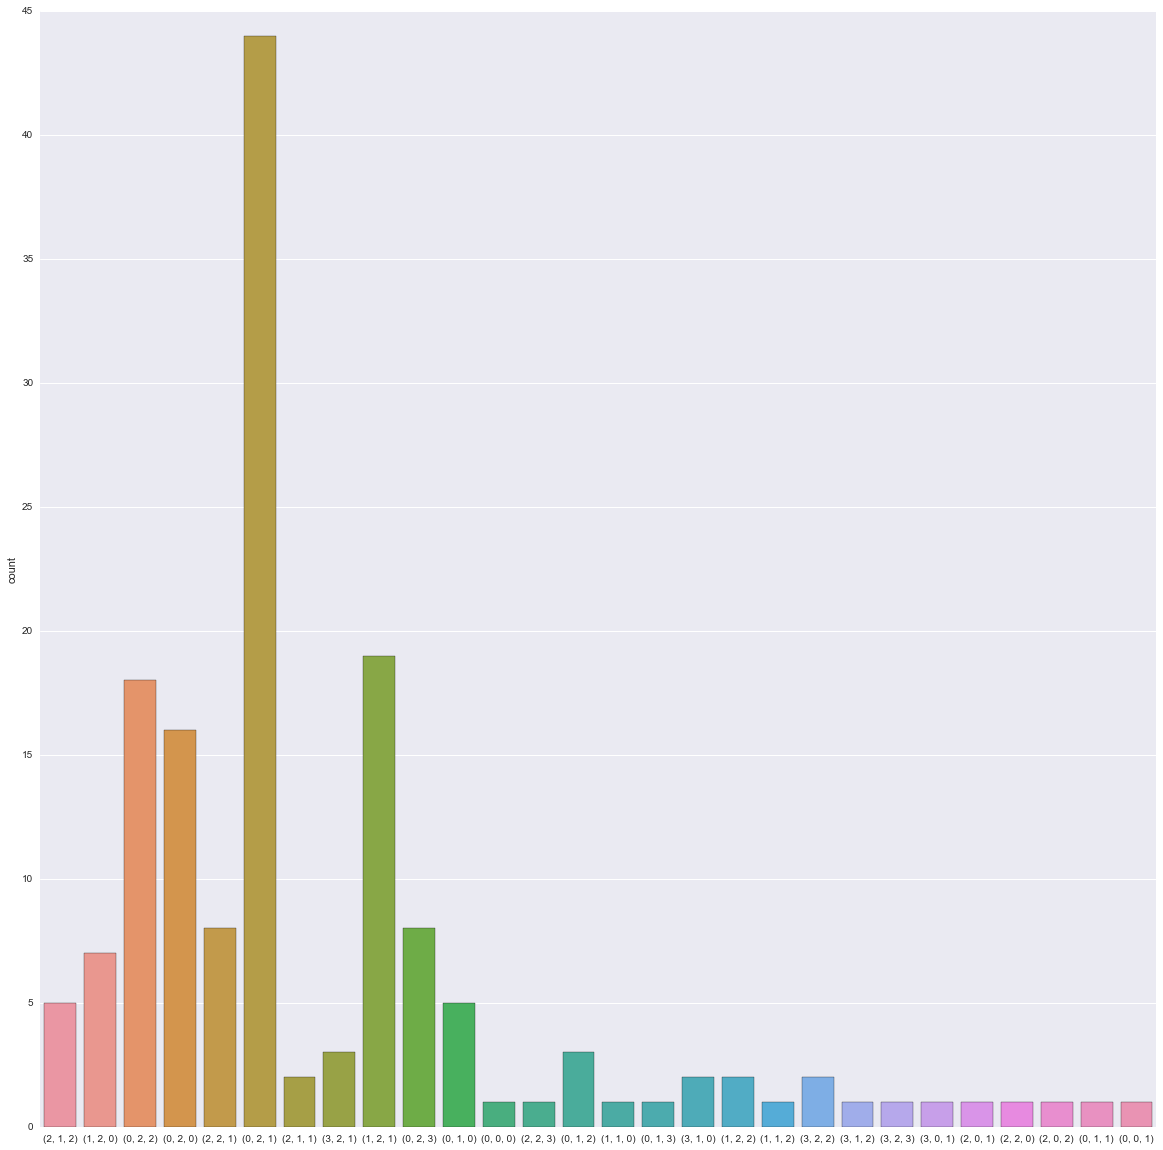

In [23]:
pyplot.figure(figsize=(20,20))
seaborn.countplot([str( i[0]) for i in result])

In [25]:
help(poisson)

Help on poisson_gen in module scipy.stats._discrete_distns object:

class poisson_gen(scipy.stats._distn_infrastructure.rv_discrete)
 |  A Poisson discrete random variable.
 |  
 |  %(before_notes)s
 |  
 |  Notes
 |  -----
 |  The probability mass function for `poisson` is::
 |  
 |      poisson.pmf(k) = exp(-mu) * mu**k / k!
 |  
 |  for ``k >= 0``.
 |  
 |  `poisson` takes ``mu`` as shape parameter.
 |  
 |  %(after_notes)s
 |  
 |  %(example)s
 |  
 |  Method resolution order:
 |      poisson_gen
 |      scipy.stats._distn_infrastructure.rv_discrete
 |      scipy.stats._distn_infrastructure.rv_generic
 |      builtins.object
 |  
 |  Methods inherited from scipy.stats._distn_infrastructure.rv_discrete:
 |  
 |  __init__(self, a=0, b=inf, name=None, badvalue=None, moment_tol=1e-08, values=None, inc=1, longname=None, shapes=None, extradoc=None, seed=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cdf(self, k, *args, **kwds)
 |      Cumulative dis